In [6]:
# Cell 1: import library

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

%matplotlib inline


In [7]:
# Cell 2: setup skenario dan generator data sintetis

countries = ["Japan", "Indonesia", "China"]
categories = ["Food", "Electronics", "Fashion", "Other"]
n_hours = 24  # 0..23

def generate_synthetic_matrix(country, n_hours=24, n_categories=4, random_state=None):
    """
    Membuat matrix [jam x kategori] berisi 'intensitas belanja' sintetis
    untuk satu negara.
    Nilai lebih besar = lebih banyak transaksi pada jam-kategori itu.
    """
    rng = np.random.default_rng(random_state)
    
    # baseline random
    M = rng.poisson(lam=5, size=(n_hours, n_categories)).astype(float)
    
    # Tambahkan pola khas negara (hanya contoh main-main)
    hours = np.arange(n_hours)
    
    if country == "Japan":
        # Rush hour: Electronics & Other ramai di pagi & malam (commuting)
        for cat_idx in [1, 3]:
            M[:, cat_idx] += 15 * np.exp(-0.5 * ((hours - 8) / 2)**2)
            M[:, cat_idx] += 15 * np.exp(-0.5 * ((hours - 20) / 2)**2)
        # Late night convenience store (Food & Other)
        for cat_idx in [0, 3]:
            M[:, cat_idx] += 8 * np.exp(-0.5 * ((hours - 23) / 3)**2)
    
    elif country == "Indonesia":
        # Puncak belanja malam (Food & Fashion)
        for cat_idx in [0, 2]:
            M[:, cat_idx] += 18 * np.exp(-0.5 * ((hours - 20) / 3)**2)
        # Siang hari belanja kebutuhan rumah (Other)
        M[:, 3] += 10 * np.exp(-0.5 * ((hours - 12) / 2.5)**2)
    
    elif country == "China":
        # Jam kantor & belanja online jam istirahat/ malam (Electronics, Fashion)
        for cat_idx in [1, 2]:
            M[:, cat_idx] += 12 * np.exp(-0.5 * ((hours - 13) / 2.5)**2)
            M[:, cat_idx] += 12 * np.exp(-0.5 * ((hours - 21) / 2.5)**2)
        # Food ramai jam makan
        for peak in [8, 12, 19]:
            M[:, 0] += 10 * np.exp(-0.5 * ((hours - peak) / 1.5)**2)
    
    # Pastikan tidak ada nilai negatif
    M = np.clip(M, 0, None)
    return M

# Contoh generate satu negara untuk cek
M_japan = generate_synthetic_matrix("Japan", random_state=0)
M_japan.shape


(24, 4)

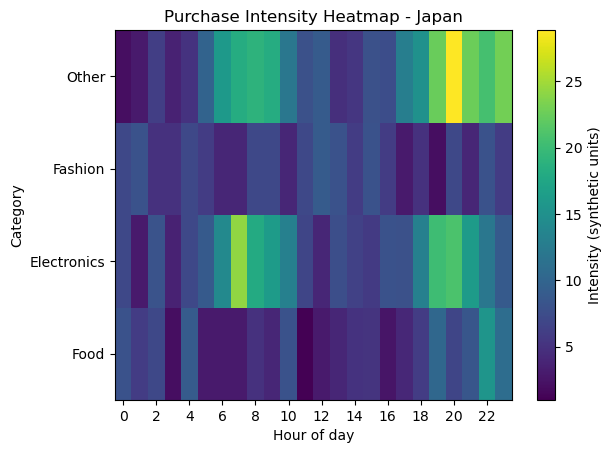

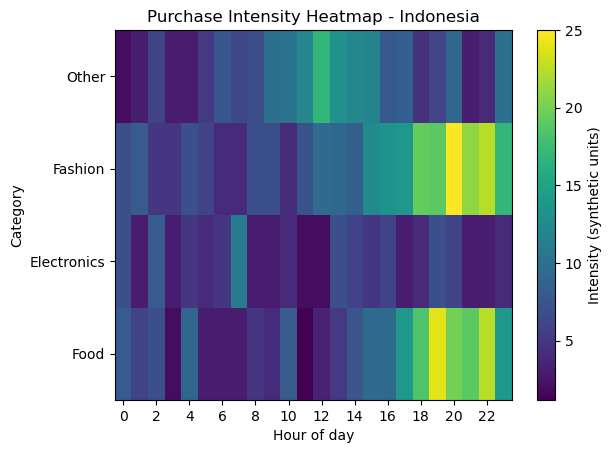

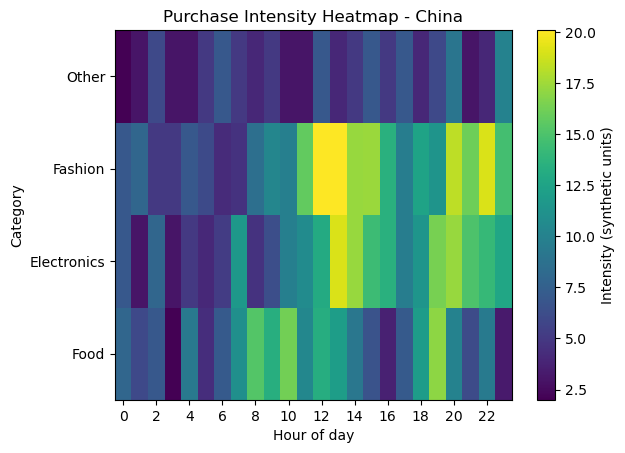

In [8]:
# Cell 3: plot heatmap matrix jam x kategori untuk tiap negara

def plot_heatmap(M, country, categories):
    plt.imshow(M.T, aspect="auto", origin="lower")
    plt.colorbar(label="Intensity (synthetic units)")
    plt.yticks(range(len(categories)), categories)
    plt.xticks(range(0, 24, 2))
    plt.xlabel("Hour of day")
    plt.ylabel("Category")
    plt.title(f"Purchase Intensity Heatmap - {country}")
    plt.show()

matrices = {}
for c in countries:
    M = generate_synthetic_matrix(c, random_state=42)
    matrices[c] = M
    plot_heatmap(M, c, categories)


In [9]:
# Cell 4: fungsi untuk menjalankan DBSCAN di matrix jam x kategori

def matrix_to_points(M, value_threshold):
    """
    Mengubah matrix M[jam, kategori] menjadi kumpulan titik (hour, category_index)
    hanya untuk sel dengan nilai >= value_threshold.
    """
    points = []
    for h in range(M.shape[0]):
        for c_idx in range(M.shape[1]):
            if M[h, c_idx] >= value_threshold:
                points.append([h, c_idx])
    return np.array(points)

def run_dbscan_on_matrix(M, eps=0.5, min_samples=3, value_threshold=None):
    """
    Jalankan DBSCAN pada titik yang diambil dari matrix M.
    value_threshold: hanya sel dengan nilai >= threshold yang diambil jadi titik.
                     jika None, otomatis pakai percentile tinggi (mis. 75%).
    """
    if value_threshold is None:
        value_threshold = np.percentile(M, 75)  # ambil kuartil atas
    
    X = matrix_to_points(M, value_threshold)
    if X.size == 0:
        print("Tidak ada titik di atas threshold, coba turunkan value_threshold.")
        return None, None, value_threshold
    
    # Scale fitur (hour, category_index) supaya DBSCAN lebih stabil
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X_scaled)
    
    return X, labels, value_threshold


=== Japan ===


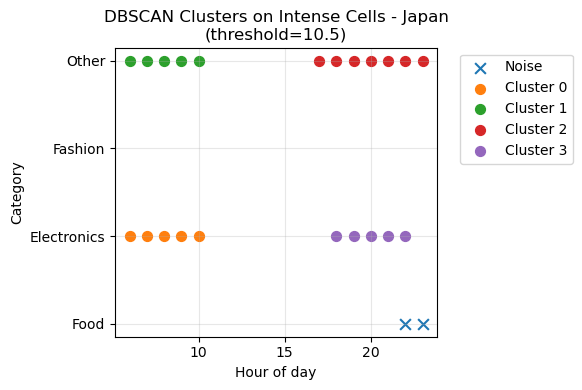

=== Indonesia ===


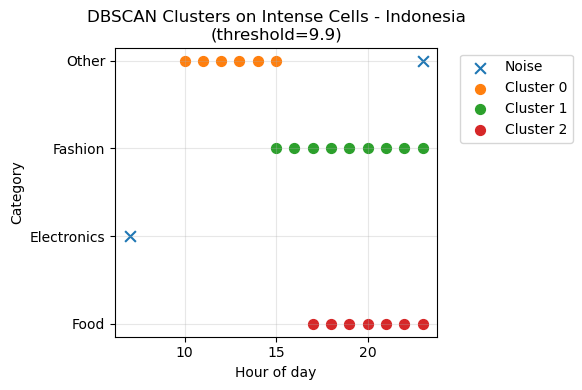

=== China ===


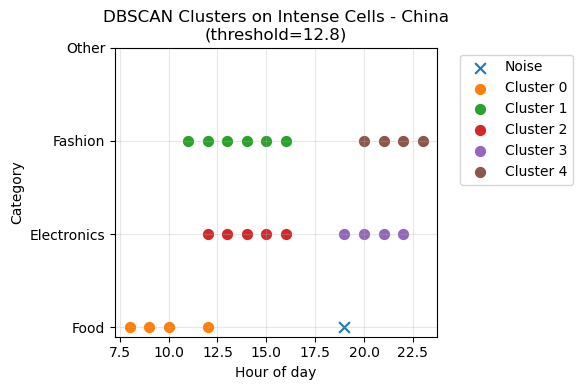

In [10]:
# Cell 5: jalankan DBSCAN & plot titik cluster di atas sumbu (jam, kategori)

def plot_dbscan_clusters(X, labels, country, categories, value_threshold):
    if X is None:
        return
    
    unique_labels = sorted(set(labels))
    
    plt.figure(figsize=(6, 4))
    
    for lab in unique_labels:
        mask = (labels == lab)
        if lab == -1:
            plt.scatter(X[mask, 0], X[mask, 1],
                        marker="x", s=60, label="Noise")
        else:
            plt.scatter(X[mask, 0], X[mask, 1],
                        s=50, label=f"Cluster {lab}")
    
    plt.yticks(range(len(categories)), categories)
    plt.xlabel("Hour of day")
    plt.ylabel("Category")
    plt.title(f"DBSCAN Clusters on Intense Cells - {country}\n(threshold={value_threshold:.1f})")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# Coba untuk semua negara
for c in countries:
    print(f"=== {c} ===")
    M = matrices[c]
    X, labels, thr = run_dbscan_on_matrix(
        M,
        eps=0.6,          # bisa kamu coba ubah
        min_samples=3,    # bisa kamu ubah juga
        value_threshold=None  # auto pakai 75th percentile
    )
    plot_dbscan_clusters(X, labels, c, categories, thr)
